# 1. 모듈, 라이브러리 불러오기

In [1]:
import numpy as np
import os
import tarfile
import urllib.request
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# 사전 학습된 Xception, MobileNet 활용
from tensorflow.keras.applications import Xception, MobileNet
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D,BatchNormalization,Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adagrad

In [4]:
# import pathlib
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file(origin=dataset_url,
#                                    fname='flower_photos',
#                                    untar=True)
# data_dir = pathlib.Path(data_dir)

# 2. 이미지 불러온 후에, train / validation / test 나누기

In [5]:
url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
filename = "flower_photos.tgz"
urllib.request.urlretrieve(url, filename)

with tarfile.open(filename, "r:gz") as tar:
    tar.extractall()

data_dir = "flower_photos"
os.makedirs(data_dir, exist_ok=True)

In [6]:
classes = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]
for c in classes:
    os.makedirs(os.path.join(data_dir, "train", c), exist_ok=True)
    os.makedirs(os.path.join(data_dir, "validation", c), exist_ok=True)
    os.makedirs(os.path.join(data_dir, "test", c), exist_ok=True)

In [7]:
class_files = {}
for c in classes:
    class_files[c] = os.listdir(os.path.join(data_dir, c))

In [8]:
split_ratio = (0.8, 0.1, 0.1)

for c in classes:
    files = class_files[c]
    num_files = len(files)
    num_train = int(num_files * split_ratio[0])
    num_validation = int(num_files * split_ratio[1])

    train_files = files[:num_train]
    validation_files = files[num_train:num_train + num_validation]
    test_files = files[num_train + num_validation:]

    for f in train_files:
        src = os.path.join(data_dir, c, f)
        dst = os.path.join(data_dir, "train", c, f)
        os.rename(src, dst)

    for f in validation_files:
        src = os.path.join(data_dir, c, f)
        dst = os.path.join(data_dir, "validation", c, f)
        os.rename(src, dst)

    for f in test_files:
        src = os.path.join(data_dir, c, f)
        dst = os.path.join(data_dir, "test", c, f)
        os.rename(src, dst)

### 단순히 이미지 샘플 출력을 위한 생성기

In [9]:
train_dir = "flower_photos/train"
validation_dir = "flower_photos/validation"
test_dir = "flower_photos/test"

image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=None)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

print(train_generator.class_indices)

Found 2934 images belonging to 5 classes.
{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


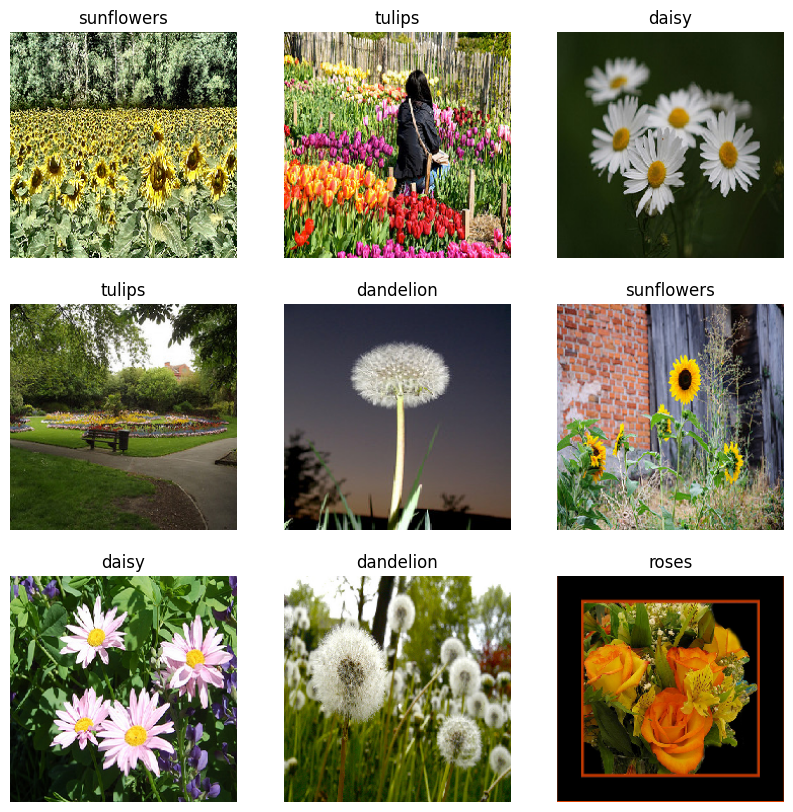

In [10]:
images, labels = next(train_generator)

plt.figure(figsize = (10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].astype('uint8'))
    plt.title(list(train_generator.class_indices.keys())[labels[i].argmax()])
    plt.axis('off')

plt.show()

In [11]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


print(train_generator.class_indices)

Found 2934 images belonging to 5 classes.
Found 364 images belonging to 5 classes.
Found 372 images belonging to 5 classes.
{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


# 3. 모델 설계하기

In [12]:
height = 224
width = 224

xception_base = Xception(include_top = False, weights = 'imagenet', input_shape = (height, width, 3))
xception_base.trainable = False

mobilenet_base = MobileNet(include_top = False, weights = 'imagenet', input_shape = (height, width, 3))
mobilenet_base.trainable = False

17225924/17225924 [==============================] - 0s 0us/step


In [13]:
print(xception_base.summary())
print(mobilenet_base.summary())

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [45]:
# xception_model = Sequential(
#     [xception_base,
#      Flatten(),
#      Dense(512, activation = 'relu'),
#      Dropout(0.2),
#      Dense(5, activation = 'softmax')]
#     )

# mobilenet_model = Sequential(
#     [mobilenet_base,
#      Flatten(),
#      Dense(512, activation = 'relu'),
#      Dropout(0.2),
#      Dense(5, activation = 'softmax')]
#     )

In [15]:
model1 = Sequential()
model1.add(xception_base)
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(2, 2))
model1.add(BatchNormalization())
# # model1.add(Conv2D(128, (3, 3), activation='relu'))
# # model1.add(MaxPooling2D(2, 2))
# # model1.add(BatchNormalization())

model1.add(Flatten())
model1.add(Dropout(0.3))
model1.add(Dense(512, activation='relu'))
model1.add(Dense(5, activation='softmax'))

# model1.add(GlobalAveragePooling2D())
# model1.add(Dense(256, activation='relu'))
# model1.add(Dense(5, activation='softmax'))

model2 = Sequential()
model2.add(mobilenet_base)
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(2, 2))
model2.add(BatchNormalization())
# # model2.add(Conv2D(128, (3, 3), activation='relu'))
# # model2.add(MaxPooling2D(2, 2))
# # model2.add(BatchNormalization())

model2.add(Flatten())
model2.add(Dropout(0.3))
model2.add(Dense(512, activation='relu'))
model2.add(Dense(5, activation='softmax'))

# model2.add(GlobalAveragePooling2D())
# model2.add(Dense(256, activation='relu'))
# model2.add(Dense(5, activation='softmax'))

print(model1.summary())
print(model2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 conv2d_6 (Conv2D)           (None, 5, 5, 64)          1179712   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 64)         0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 2, 2, 64)         256       
 hNormalization)                                                 
                                                                 
 flatten_2 (Flatten)         (None, 256)               0         
                                                                 
 dropout_2 (Dropout)         (None, 256)              

In [16]:
lr = 0.0001

model1.compile(loss = 'categorical_crossentropy',
                       optimizer = Adam(learning_rate = lr),
                       metrics = ['accuracy'])
model2.compile(loss = 'categorical_crossentropy',
                        optimizer = Adagrad(learning_rate = lr),
                        metrics = ['accuracy'])

In [17]:
epochs = 10

history1 = model1.fit(train_generator,
                               epochs = epochs,
                               validation_data = validation_generator)

Epoch 1/10
92/92 [==============================] - 35s 219ms/step - loss: 0.6463 - accuracy: 0.7624 - val_loss: 0.5046 - val_accuracy: 0.8132
Epoch 2/10
92/92 [==============================] - 18s 191ms/step - loss: 0.3063 - accuracy: 0.8981 - val_loss: 0.4690 - val_accuracy: 0.8434
Epoch 3/10
92/92 [==============================] - 18s 191ms/step - loss: 0.1913 - accuracy: 0.9434 - val_loss: 0.4431 - val_accuracy: 0.8544
Epoch 4/10
92/92 [==============================] - 18s 190ms/step - loss: 0.1271 - accuracy: 0.9649 - val_loss: 0.4668 - val_accuracy: 0.8407
Epoch 5/10
92/92 [==============================] - 17s 184ms/step - loss: 0.0841 - accuracy: 0.9806 - val_loss: 0.4717 - val_accuracy: 0.8242
Epoch 6/10
92/92 [==============================] - 18s 191ms/step - loss: 0.0569 - accuracy: 0.9860 - val_loss: 0.4769 - val_accuracy: 0.8352
Epoch 7/10
92/92 [==============================] - 17s 188ms/step - loss: 0.0434 - accuracy: 0.9905 - val_loss: 0.5043 - val_accuracy: 0.8462

In [18]:
history2 = model2.fit(train_generator,
                                epochs = epochs,
                                validation_data = validation_generator)

Epoch 1/10
92/92 [==============================] - 18s 166ms/step - loss: 1.6424 - accuracy: 0.2904 - val_loss: 1.4703 - val_accuracy: 0.3736
Epoch 2/10
92/92 [==============================] - 14s 153ms/step - loss: 1.3470 - accuracy: 0.4380 - val_loss: 1.2646 - val_accuracy: 0.4643
Epoch 3/10
92/92 [==============================] - 15s 158ms/step - loss: 1.1952 - accuracy: 0.5286 - val_loss: 1.1426 - val_accuracy: 0.5659
Epoch 4/10
92/92 [==============================] - 14s 152ms/step - loss: 1.0751 - accuracy: 0.5937 - val_loss: 1.0530 - val_accuracy: 0.6264
Epoch 5/10
92/92 [==============================] - 14s 157ms/step - loss: 0.9895 - accuracy: 0.6462 - val_loss: 0.9823 - val_accuracy: 0.6511
Epoch 6/10
92/92 [==============================] - 16s 169ms/step - loss: 0.9034 - accuracy: 0.6823 - val_loss: 0.9283 - val_accuracy: 0.6786
Epoch 7/10
92/92 [==============================] - 14s 157ms/step - loss: 0.8541 - accuracy: 0.7178 - val_loss: 0.8832 - val_accuracy: 0.7115

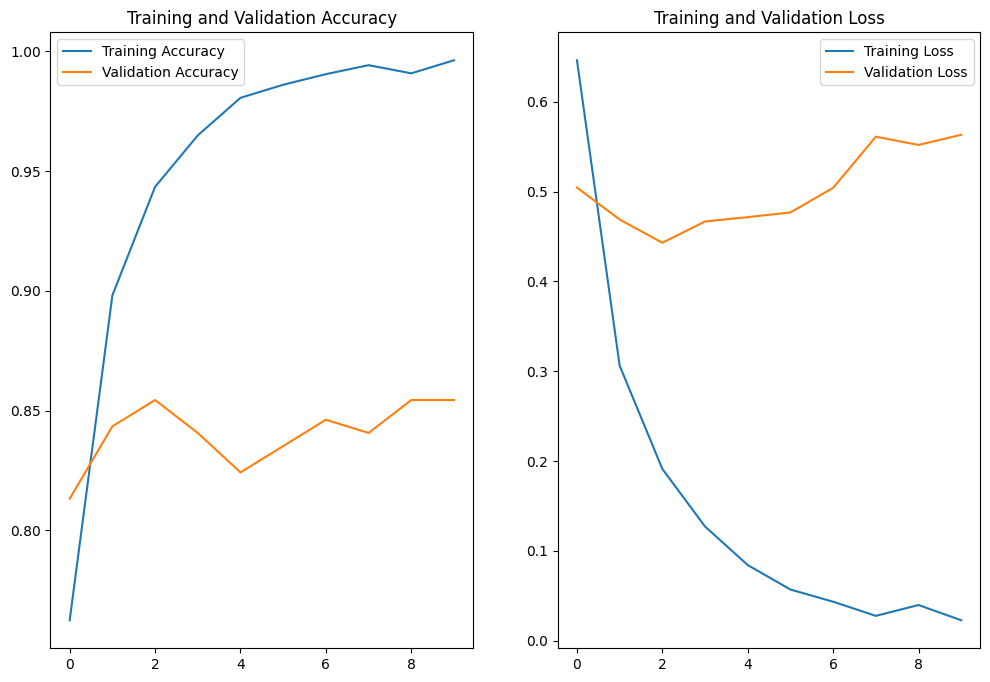

In [19]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

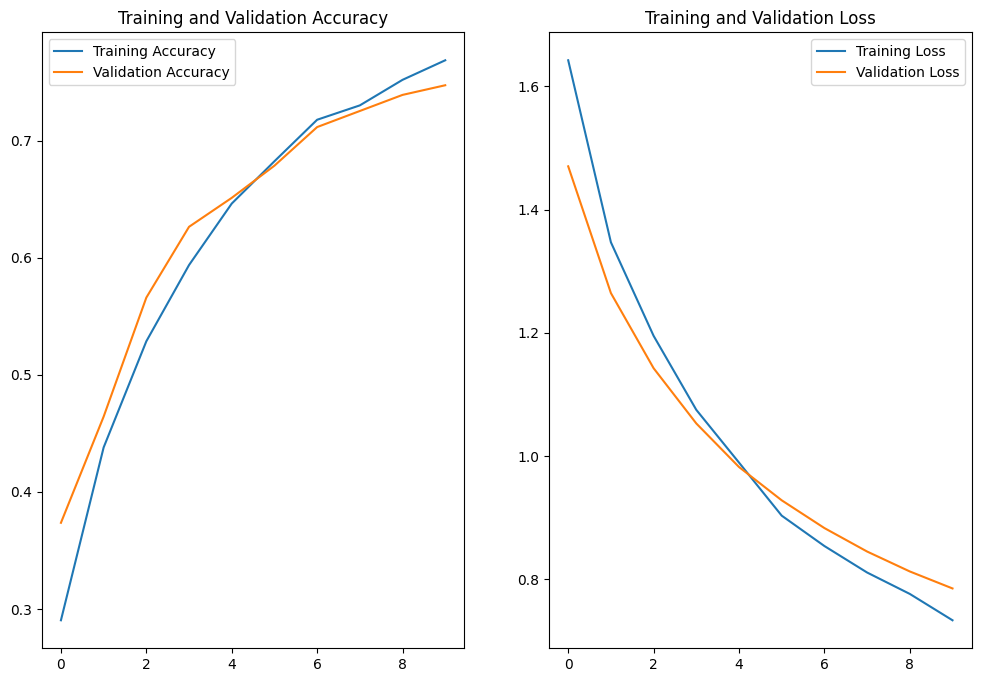

In [20]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc2, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc2, label = 'Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss2, label = 'Training Loss')
plt.plot(epochs_range, val_loss2, label = 'Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [21]:
test_loss, test_accuracy = model1.evaluate(test_generator)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)

12/12 [==============================] - 3s 274ms/step - loss: 0.5052 - accuracy: 0.8548
Test Loss:  0.5051509737968445
Test Accuracy:  0.8548387289047241
